In [1]:
import pandas
import datetime
import numpy
from sklearn import linear_model
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean"], ascending=False ).reset_index(drop=True)
# velGmagDF.head()
velGmagDF["dst_bin"].unique()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


array(['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-75, -50]', '(-150, -75]'], dtype=object)

In [4]:
# scale, mlat --> polynomial fit
# scale, norm_mlt --> linear

# shape, mlat  --> linear
# shape, norm_mlt  --> linear

#loc, mlat --> exponential
#loc, norm_mlt --> linear

In [5]:
# read data from the lshell file
fitSgDF = pandas.read_csv("../data/fit-skewed-gaussian.txt", sep=' ')
fitSgDF.head()

,dst_bin,dst_mean,loc,mlat,norm_mlt,scale,shape
0,"(-10, 10]",-3,193.343048,58.0,1.0,350.289070,77.307753
1,"(-25, -10]",-17,209.169066,58.0,1.0,420.156530,25.834191
2,"(-50, -25]",-36,229.189543,58.0,1.0,393.217864,17.229693
3,"(-10, 10]",-3,286.660543,61.0,1.0,367.835992,12.436087
4,"(-25, -10]",-17,267.437051,61.0,1.0,305.736732,9.318884


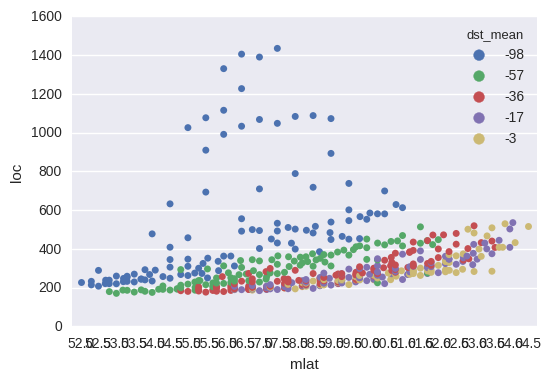

In [6]:
selParam = "loc"
selDF = fitSgDF#[ (fitSgDF["dst_bin"] == "(-150, -75]") ] # & (fitSgDF["norm_mlt"] == -6.)
sns.swarmplot( x="mlat", y=selParam, hue="dst_mean", data=selDF[ ["mlat", "norm_mlt", "dst_bin", "dst_mean" , selParam] ])

In [7]:
# scale, mlat --> polynomial fit
# scale, norm_mlt --> linear
##########
# shape, mlat  --> linear
# shape, norm_mlt  --> linear
#########
#loc, mlat --> exponential
#loc, norm_mlt --> linear

# Select a subset for testing the fits
selDstBin = "(-150, -75]"
testFitDF = fitSgDF[ (fitSgDF["dst_bin"] == selDstBin) ]
# scale, mlat Fit
pfScaleMlat = numpy.polyfit(testFitDF["mlat"], testFitDF["scale"], 2)
pvScaleMlat = numpy.poly1d(pfScaleMlat)
# scale, norm_mlt Fit
scaleMLTFit = linear_model.LinearRegression().fit(testFitDF[ ["norm_mlt"] ], testFitDF["scale"])
# shape, mlat Fit
shapeMLATFit = linear_model.LinearRegression().fit(testFitDF[ ["mlat"] ], testFitDF["shape"])
# shape, norm_mlt Fit
shapeMLTFit = linear_model.LinearRegression().fit(testFitDF[ ["norm_mlt"] ], testFitDF["shape"])
# loc, mlat Fit
locMLATFit, parm_cov = scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),\
                                                testFitDF["mlat"],  testFitDF["loc"],  p0=(4, 0.1))
locMLATVals = locMLATFit[0]*numpy.exp(locMLATFit[1]*testFitDF["mlat"])
# loc, norm_mlt Fit
locMLTFit = linear_model.LinearRegression().fit(testFitDF[ ["norm_mlt"] ], testFitDF["loc"])

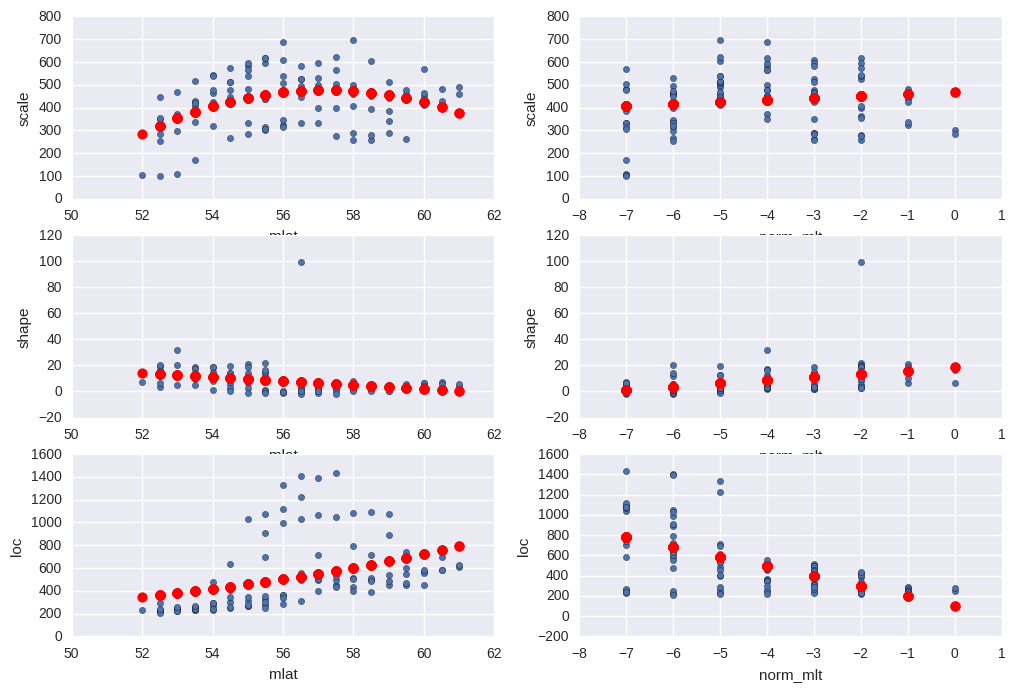

In [8]:
# PLOT THE FITS
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)
ax6 = f.add_subplot(3,2,6)
# set styling
sns.set_style("darkgrid")
sns.set_context("paper")
#### SCALE PARAMS ####
#### SCALE PARAMS ####
# mlat, scale fit plot
testFitDF.plot( x="mlat", y="scale", kind="scatter", ax=ax1)
ax1.scatter( testFitDF["mlat"], pvScaleMlat(testFitDF["mlat"]),50, color="red")
# norm_mlt, scale fit plot
testFitDF.plot( x="norm_mlt", y="scale", kind="scatter", ax=ax2)
ax2.scatter( testFitDF["norm_mlt"], scaleMLTFit.predict(testFitDF[ ["norm_mlt"] ]),50, color="red")
#### SCALE PARAMS ####
#### SCALE PARAMS ####
#### SHAPE PARAMS ####
#### SHAPE PARAMS ####
# mlat, shape fit plot
testFitDF.plot( x="mlat", y="shape", kind="scatter", ax=ax3)
ax3.scatter( testFitDF["mlat"], shapeMLATFit.predict(testFitDF[ ["mlat"] ]),50, color="red")
# norm_mlt, shape fit plot
testFitDF.plot( x="norm_mlt", y="shape", kind="scatter", ax=ax4)
ax4.scatter( testFitDF["norm_mlt"], shapeMLTFit.predict(testFitDF[ ["norm_mlt"] ]),50, color="red")
#### SHAPE PARAMS ####
#### SHAPE PARAMS ####
#### LOC PARAMS ####
#### LOC PARAMS ####
# mlat, shape fit plot
testFitDF.plot( x="mlat", y="loc", kind="scatter", ax=ax5)
ax5.scatter( testFitDF["mlat"], locMLATVals,50, color="red")
# norm_mlt, shape fit plot
testFitDF.plot( x="norm_mlt", y="loc", kind="scatter", ax=ax6)
ax6.scatter( testFitDF["norm_mlt"], locMLTFit.predict(testFitDF[ ["norm_mlt"] ]),50, color="red")
#### LOC PARAMS ####
#### LOC PARAMS ####

In [9]:
def scale_fit_func((mlt,mlat), a_scale_mlt, b_scale_mlt, c_scale_mlt, a_scale_mlat, b_scale_mlat):
    
    g = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return g.ravel()

def scale_pred_func(mlt,mlat):
    
    initGuess = ( -1e+4, 1e3, -10, 100, 10 )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
    popt2, pcov2 = curve_fit(scale_fit_func, (testFitDF['norm_mlt'].T,testFitDF['mlat'].T), testFitDF['scale'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_scale_mlt, b_scale_mlt, c_scale_mlt,\
         a_scale_mlat, b_scale_mlat ) = tuple( popt2.tolist() )
    
    g = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    return g.ravel()

testFitDF["pred_scale"] = scale_pred_func( testFitDF["norm_mlt"], testFitDF["mlat"] )

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
def shape_fit_func((mlt,mlat), a_shape_mlt, b_shape_mlt, a_shape_mlat, b_shape_mlat):
    
    g = ( a_shape_mlt + b_shape_mlt*(mlt) ) * ( a_shape_mlat + b_shape_mlat*(mlat) )
    
    return g.ravel()

def shape_pred_func(mlt,mlat):
    
    initGuess = ( 1, 10, -1, 100 )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
    popt2, pcov2 = curve_fit(shape_fit_func, (testFitDF['norm_mlt'].T,testFitDF['mlat'].T), testFitDF['shape'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_shape_mlt, b_shape_mlt, a_shape_mlat, b_shape_mlat ) = tuple( popt2.tolist() )
    
    g = ( a_shape_mlt + b_shape_mlt*(mlt) ) * ( a_shape_mlat + b_shape_mlat*(mlat) )
    
    return g.ravel()

testFitDF["pred_shape"] = shape_pred_func( testFitDF["norm_mlt"], testFitDF["mlat"] )

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
def loc_fit_func((mlt,mlat), a_loc_mlt, b_loc_mlt, a_loc_mlat, b_loc_mlat):
    
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat*numpy.exp(b_loc_mlat*mlat) )
    
    return g.ravel()


def loc_pred_func(mlt,mlat):
    
    initGuess = ( -100, 100, 4, 0.1 )#(3,0.001,2,0.001,4,0.05,-0.5,0.05,1,0.001,1)
    popt2, pcov2 = curve_fit(loc_fit_func, (testFitDF['norm_mlt'].T,testFitDF['mlat'].T), testFitDF['loc'],
                           p0=initGuess)    
#     print popt2
#     print "-----------"
#     print pcov2
    ( a_loc_mlt, b_loc_mlt, a_loc_mlat, b_loc_mlat ) = tuple( popt2.tolist() )
    
    g = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat*numpy.exp(b_loc_mlat*mlat) )
    
    return g.ravel()


testFitDF["pred_loc"] = loc_pred_func( testFitDF["norm_mlt"], testFitDF["mlat"] )

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


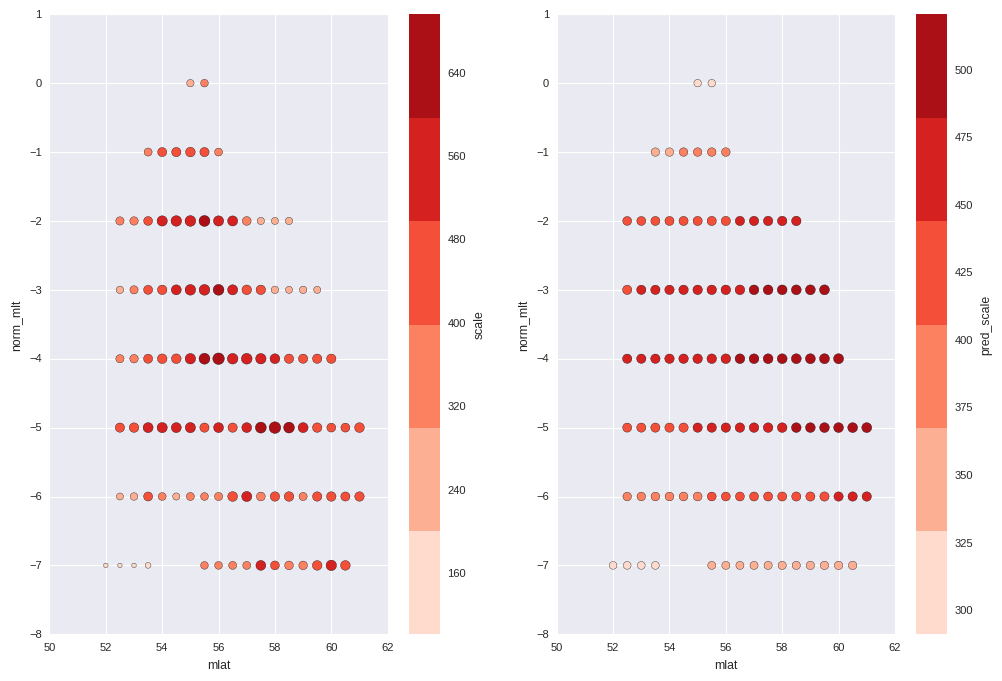

In [12]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

testFitDF.plot( kind='scatter',
              x='mlat',
              y='norm_mlt',
              c='scale',
              s=testFitDF['scale']/10, cmap=seaMap,ax=ax1)

testFitDF.plot( kind='scatter',
              x='mlat',
              y='norm_mlt',
              c='pred_scale',
              s=testFitDF['pred_scale']/10, cmap=seaMap,ax=ax2)

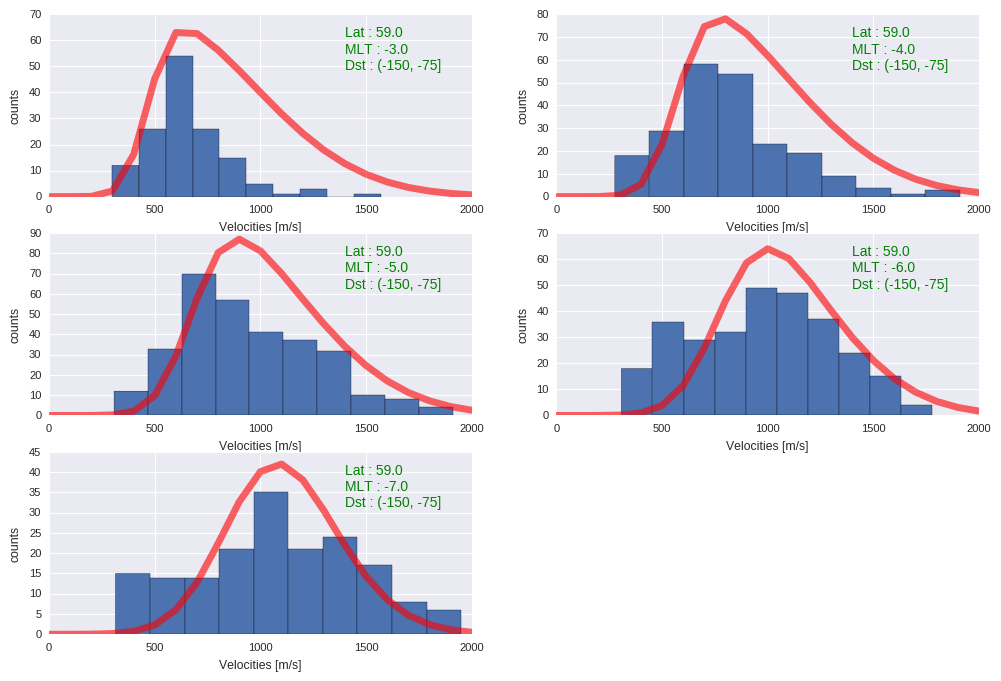

In [15]:
# Make a few plots of the fitting to get an estimate of how things are!
# Our velocities range from 0 to 2000 m/s
velsArr = numpy.arange(0.,2100.,100.)
selMLAT = 59.#59.5#
selNormMLT = -3.#-6.#
selFitDF = testFitDF[ (testFitDF["dst_bin"] == selDstBin) &\
                (testFitDF["mlat"] == selMLAT) ]
selVelDF = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin) & \
                  (velGmagDF["MLAT"] == selMLAT) ]
# get dst mean for the selected bin
dstMeanValCurrBin = velGmagDF[ (velGmagDF["dst_bin"] == selDstBin)\
                      ]["dst_index"].unique()[0]
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) ) 
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )
for ind, currNormMLT in enumerate( numpy.sort( selVelDF["normMLT"].unique() )[::-1] ):
    shape = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_shape"].tolist()[0]
    loc = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_loc"].tolist()[0]
    scale = selFitDF[ selFitDF["norm_mlt"] == currNormMLT ]["pred_scale"].tolist()[0]
    subVelDF = selVelDF[ selVelDF["normMLT"] == currNormMLT ]
    velScale = subVelDF["vSaps"].value_counts(bins=velsArr[::2]).max()
    pdf_fitted = scipy.stats.skewnorm.pdf(velsArr, shape, loc, scale)
    fitVals = pdf_fitted/max(pdf_fitted) * velScale
    axArr[ind].plot(velsArr, fitVals, 'r-', lw=5, alpha=0.6)
    axArr[ind].set_xlabel("Velocities [m/s]")
    axArr[ind].set_ylabel("counts")
    printText = "Lat : " + str(selMLAT) +\
                "\n" + "MLT : " + str(currNormMLT) +\
                "\n" + "Dst : " + selDstBin
    axArr[ind].text(0.7, 0.7,  printText,
            transform=axArr[ind].transAxes,
            color='green', fontsize=10)
    subVelDF["vSaps"].hist(ax=axArr[ind])
    axArr[ind].set_xlim( [0,2000] )
# plt.savefig("../figs/skewed-gaussian-fit-test.pdf",bbox_inches='tight')